# Dogs vs cats classifier

This notebook shows the building of a neural network for classifying pictures of Dogs and Cats. It is based on the [guided example from Keras documentation](https://keras.io/examples/vision/image_classification_from_scratch/). The solution is organized aiming to replicate a production environment, which is why some explanations from the original example were removed.

## Data aqcuisition
The data was exported from the suggested URL, but it turned out to be a broken link. Then the filename below was supplied, which allowed to work with.

In [1]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   244M      0  0:00:03  0:00:03 --:--:--  244M


In [2]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'


In [3]:
!ls PetImages

Cat  Dog


## Filtering corrupted data
As stated in the example, the corrupted images (those which do not feature the string "JFIF" in their header) need to be removed from the dataset.


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


## Generating dataset
Once the corrupted images are filtered, the actual dataset is created. In the end, a total of images are being used for the experiment. To experiment with different scenarios, the seeds for the training/test split was changed.

In [5]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=518,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=518,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


## Visualizing images

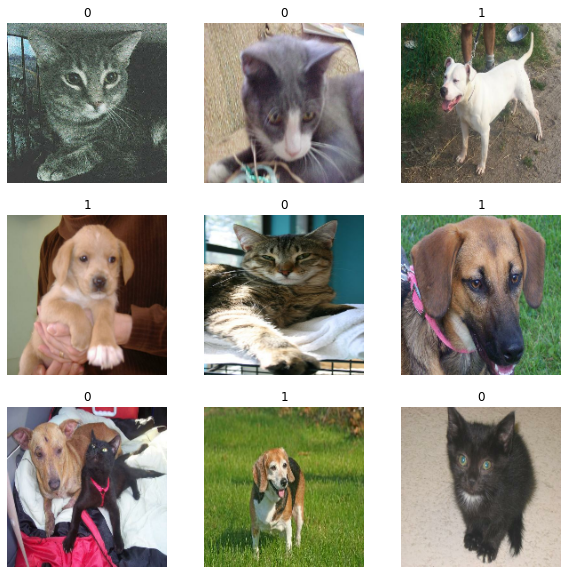

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Data augmentation
For this experiment, the proposed technique for data augmentation was implemented, to generate more samples from the given ones. This technique allow to have different possible alternatives from the same dataset. For images, this means rotating and mirroring said images to have multiple angles of the same image.

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

## Model building
The model was built using the functional approach. Taking into account the original post comments, and given that the notebook was processed entirely in Google's Colab environment, with the opportunity to select a GPU runtime. To use this advantage, this functional approach is considered best for the syncronous transformation during model processing. 

A Python function defines the model that applies the Xception network as stated by the original document. As with any convolutional network, this contains filter and pooling layers in the convolutional part, in this case adding 4 iterations with diferent sizes of 2 convolutional before one pooling layer. In the end, the function add an output layer customizable for different numbers of classes. This means the model can work for more types of images apart from this case of cats/dogs.

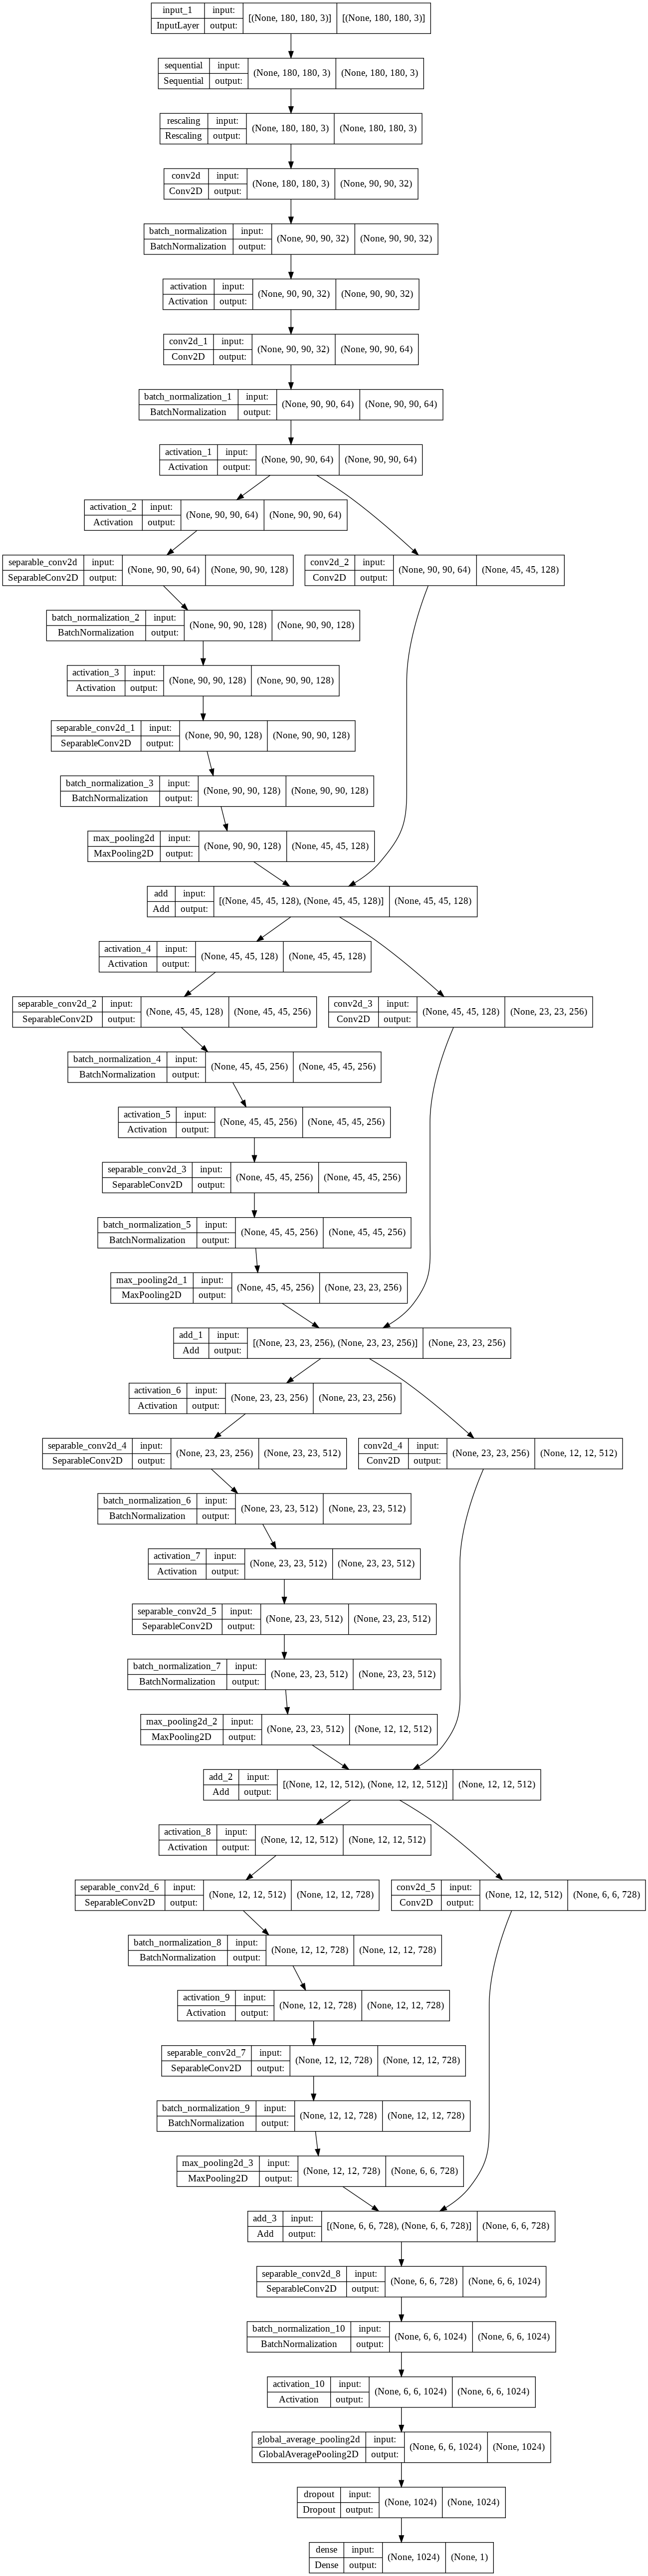

In [8]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

## Improving the performance of the dataset
The sequence of file opening and reading during training can represent an important part of the total time of training the model. That's why it's necessary to prefetch the dataset so the opening of the files and model training occurr asyncronously, effectively reducing the total time of training process. In other words, this means taking advantage of paralell processing to overlap the preprocessing and model execution of [link text](https://)a training step.

In [9]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Fitting the model
With everything set up, the model was fit. The overall training time for 50 epochs was above 2.5 hours, even when using a GPU runtime. However, it was noted during training that by epoch 15/50 the achieved accuracy was around 95% for training and 93% for validation. These metrics represent a great performance for a classification model.

In a real scenario, it should be worth considering what would be an acceptability threshold for the accuracy for the model to be considered optimal, while balancing the computational resources needed and the operation context.

If, for example, a 90% is considered appropriate, then around 10 epochs would be more than enough. In such situation, the reduced training time would allow the data scientist to try different network architecture looking for a more optimal model. Multiple models could be tested so there would be more chance to find a better approach. 

For this scenario, after 50 epochs the training accuracy reached up to ~97% while the validation accuracy only reached to ~91%. This suggest the model is overfitting the data, thus the difference in accuracies. Note that this difference is produced basically for the changes in the initial conditions of the data, because the seed for the train/test split was changed.

In [10]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
586/586 [==============================] - 171s 262ms/step - loss: 0.6072 - accuracy: 0.6787 - val_loss: 0.5186 - val_accuracy: 0.7670
Epoch 2/50
586/586 [==============================] - 152s 259ms/step - loss: 0.4424 - accuracy: 0.7957 - val_loss: 1.0872 - val_accuracy: 0.5903
Epoch 3/50
586/586 [==============================] - 151s 258ms/step - loss: 0.3494 - accuracy: 0.8499 - val_loss: 1.2814 - val_accuracy: 0.6435
Epoch 4/50
586/586 [==============================] - 151s 257ms/step - loss: 0.2938 - accuracy: 0.8763 - val_loss: 1.2177 - val_accuracy: 0.6352
Epoch 5/50
586/586 [==============================] - 151s 257ms/step - loss: 0.2516 - accuracy: 0.8947 - val_loss: 0.3457 - val_accuracy: 0.8652
Epoch 6/50
586/586 [==============================] - 151s 257ms/step - loss: 0.2168 - accuracy: 0.9115 - val_loss: 0.2325 - val_accuracy: 0.9097
Epoch 7/50
586/586 [==============================] - 151s 257ms/step - loss: 0.1971 - accuracy: 0.9200 - val_loss: 0.1725 -

## Run inference on new data
As with the given example, new data was tested for the model to predict. In this case, we're changing the approach by building a function that returns the model prediction, and then passing some images to validate. Finally, some custom images were added and tested with the function to check the model's behavior with totally unseen data.

In [11]:
def model_prediction(img_path):
  img = keras.preprocessing.image.load_img(
      img_path, target_size=image_size
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  predictions = model.predict(img_array)
  score = predictions[0]
  return(
      "This image is %.2f percent cat and %.2f percent dog."
      % (100 * (1 - score), 100 * score)
  )

In [12]:
#Cat test image
model_prediction('PetImages/Cat/6779.jpg')

This image is 24.92 percent cat and 75.08 percent dog.


In [13]:
#Dog test image
model_prediction('PetImages/Dog/1007.jpg')

This image is 0.00 percent cat and 100.00 percent dog.


Note that there are mistaken predictions, like the first Cat test, however, other tests give a confident and correct prediction. 

Let's see the behavior with custom data:

In [14]:
#Custom dog test image
model_prediction('PetImages/Dog_test.jpg')

This image is 0.06 percent cat and 99.94 percent dog.


In [15]:
#Custom cat test image
model_prediction('PetImages/Cat_test.jpeg')

This image is 99.98 percent cat and 0.02 percent dog.


The two tests with unseen images reflect a very good performance. This should be tested with more unseen data to validate the model usability in real situations. For comparisson, the test images are shown below.

In [16]:
def show_img(img_path):
  img = keras.preprocessing.image.load_img(
      img_path, target_size=image_size
  )
  plt.imshow(img)
  plt.axis("off")

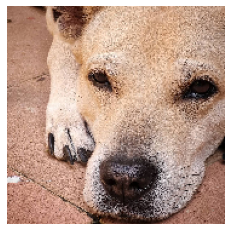

In [17]:
#Custom dog test image
show_img('PetImages/Dog_test.jpg')

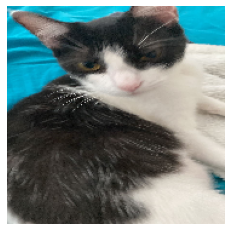

In [18]:
#Custom cat test image
show_img('PetImages/Cat_test.jpeg')

It's worth noting that even when the quality of the custom images was downgraded by the processing, the model still detects correctly to which category the image belongs. 

Another interesting experiment, just to check the model's behavior, is to load an image that does not belong to any category for training, in this case, a pigeon. Obviously, any answer that the model gives is wrong, but let's see the result.

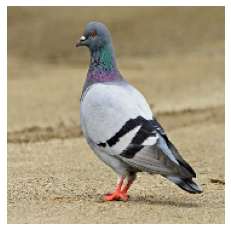

In [19]:
#Custom pigeon test image
show_img('PetImages/Pigeon_test.jpeg')

In [20]:
#Custom pigeon test image
model_prediction('PetImages/Pigeon_test.jpeg')

This image is 2.07 percent cat and 97.93 percent dog.


## Conclusion
This process helped to understand the way a CNN architecture is built from scratch. There are several considerations to make in terms of how the data is processed, what layers to use and which hyper parameters set to the model. The training process duration was considerably long, and other considerations from the business environment should be taken into account when trying to develop a model for use in production.

We could see that the model has a very good performance when the input is one of the expected categories, even with previously unseen samples. As imagined, the results for new categories are completely mistaken. In general the model has learned pretty well to distinguish the categories, and it would be interesting to run an experiment with the same architecture and more categories to classify.